# Calculating metrics

xarray is built on top of [numpy](http://numpy.org), which means it implements many of the numpy operators as native methods, and those it doesn't can still be used on the underlying numpy arrays contained with an `xarray.DataArray` object.

This is intended as a short introduction with a focus on climate data. The [xarray documentation on computation](http://xarray.pydata.org/en/stable/computation.html) is excellent and contains many more examples and much more detail.

**Note:** This notebook has been updated to include proper weighting of spatial averages

In [1]:
import xarray
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

Load a CMIP5 air temperature data set into the variable `ds`, and make a variable, `tas`, which directly references the near surface air temperature `DataArray`

In [3]:
ds = xarray.open_dataset('http://dapds00.nci.org.au/thredds/dodsC/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/mon/atmos/Amon/r1i1p1/latest/tas/tas_Amon_ACCESS1-3_historical_r1i1p1_185001-200512.nc')
tas = ds.tas

In [4]:
tas

<xarray.DataArray 'tas' (time: 1872, lat: 145, lon: 192)>
[52116480 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2005-12-16T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 ...
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    units:             K
    cell_methods:      time: mean
    cell_measures:     area: areacella
    history:           2012-02-05T23:49:51Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

It is straightforward to calculate the mean temperature for all locations and times in the data

In [5]:
tas.mean()

<xarray.DataArray 'tas' ()>
array(277.5926, dtype=float32)
Coordinates:
    height   float64 1.5

It is possible to specify a dimension along which to compute an operator. For example, to calculate the mean in time for all locations specify the `time` dimension as the dimension along which the mean should be calculated:

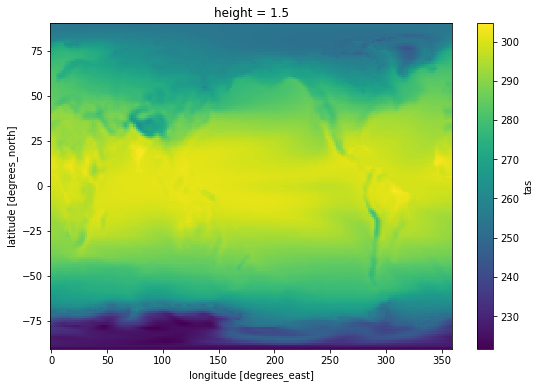

In [6]:
tas.mean(dim='time').plot(size=6)

It is common to calculate a 30-year climatology, which is simple using `sel` and chaining operators

In [7]:
tas_clim = tas.sel(time=slice('1960-01','1989-12')).mean(dim='time')
tas_clim

<xarray.DataArray 'tas' (lat: 145, lon: 192)>
array([[223.5951 , 223.5951 , 223.5951 , ..., 223.58675, 223.58675,
        223.58675],
       [227.05313, 227.00461, 226.95636, ..., 227.20116, 227.1515 ,
        227.10295],
       [228.13997, 228.0243 , 227.9114 , ..., 228.49681, 228.37773,
        228.25885],
       ...,
       [255.42877, 255.46603, 255.50294, ..., 255.29857, 255.34636,
        255.38702],
       [254.99307, 255.0079 , 255.0223 , ..., 254.94296, 254.95801,
        254.97554],
       [254.3218 , 254.3218 , 254.3218 , ..., 254.3218 , 254.3218 ,
        254.3218 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 1.5

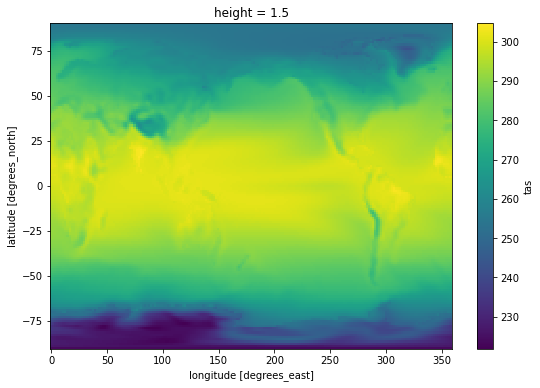

In [8]:
tas_clim.plot(size=6)

The anomaly from the 30 year climatology can now be calculated by subtracting it from the original data. xarray checks which named coordinates match between the two data sets, and *broadcasts* the `tas_clim` data along the missing `time` dimension automatically.

In [9]:
tas_anom = (tas - tas_clim)

The mean global anomaly in time can be calculated by specifying both `lat` and `lon` dimensions in the `dim` argument to `mean`

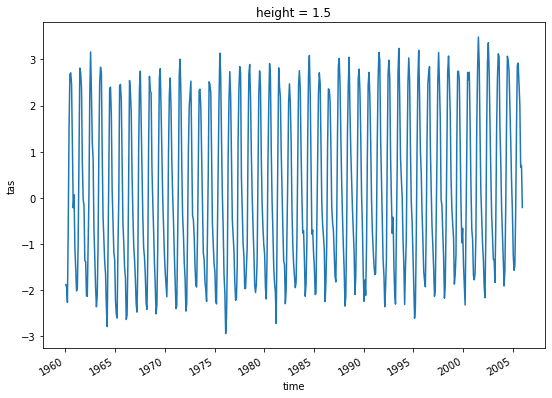

In [10]:
tas_anom.sel(time=slice('1960-01',None)).mean(dim=('lat','lon')).plot(size=6)

Note the above plot made use of an open-ended `slice` by specifying `None` as the second argument, which places no upper limit on the `slice` operation.

<b>Update:</b> An operation which combines grid cells of different size is not scientifically valid unless each cell is weighted by the size of the grid cell. `xarray` has a convenient [weighted](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.weighted.html) method to accomplish this

First need to load the cell area data for this model

In [11]:
areacella = xarray.open_dataset('http://dapds00.nci.org.au/thredds/dodsC/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/fx/atmos/fx/r0i0p0/latest/areacella/areacella_fx_ACCESS1-3_historical_r0i0p0.nc').areacella
areacella

<xarray.DataArray 'areacella' (lat: 145, lon: 192)>
array([[7.900114e+07, 7.900114e+07, 7.900114e+07, ..., 7.900114e+07,
        7.900114e+07, 7.900114e+07],
       [6.319696e+08, 6.319696e+08, 6.319696e+08, ..., 6.319696e+08,
        6.319696e+08, 6.319696e+08],
       [1.263641e+09, 1.263641e+09, 1.263641e+09, ..., 1.263641e+09,
        1.263641e+09, 1.263641e+09],
       ...,
       [1.263641e+09, 1.263641e+09, 1.263641e+09, ..., 1.263641e+09,
        1.263641e+09, 1.263641e+09],
       [6.319696e+08, 6.319696e+08, 6.319696e+08, ..., 6.319696e+08,
        6.319696e+08, 6.319696e+08],
       [7.900114e+07, 7.900114e+07, 7.900114e+07, ..., 7.900114e+07,
        7.900114e+07, 7.900114e+07]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:     cell_area
    long_name:         Atmosphere Grid-Cell Area
    units:             m2
    history:           2012-03-28T03:37:56Z altered by CMOR: replaced missing...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

So, as before calculate the area weighted mean of the entire dataset in space and time. It is now 10 degrees higher, as expected, as the colder (and smaller) polar cells contribute proportionally less to the mean

In [12]:
tas.weighted(areacella).mean()

<xarray.DataArray ()>
array(287.24357055)
Coordinates:
    height   float64 1.5

As above, the mean global anomaly should be weight by the cell area. Below the weighted and unweighted global mean time series are plotted in the same chart to show the area weighting has a significant effect

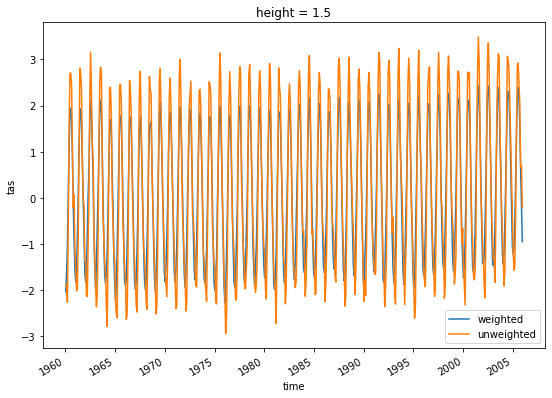

In [13]:
tas_anom.sel(time=slice('1960-01',None)).weighted(areacella).mean(dim=('lat','lon')).plot(size=6)
tas_anom.sel(time=slice('1960-01',None)).mean(dim=('lat','lon')).plot()
plt.legend(['weighted','unweighted'])